In [ ]:
!pip3 install numpy tifffile --user

In [1]:
import requests
import json
import numpy as np
import tifffile as tiff
import math
import tempfile
import os
import tiledb
import uuid

from datetime import datetime, timedelta

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
# tdmq constants
TDMQ_BASE_URL = 'http://web:8000/api/v0.0'
TILEDB_HDFS_ROOT = 'hdfs://hdfs:9000/arrays'
TDMQ_NAMESPACE_UUID = uuid.UUID('367b5aee-8609-3c20-b130-4eb927a2d62b')
TILEDB_CTX = tiledb.Ctx({'vfs.hdfs.username': 'root'})

In [4]:
dpc_meteoradar_mosaic_type = {
    "code": "0fd67c67-c9be-45c6-9719-4c4eada4ffff",
    "type": "meteoRadar",
    "name": "Mosaic of dpc meteo radars",
    "brandName": "DPC",
    "modelName": "dpc-radar-mosaic",
    "manufacturerName": "Dipartimento Protezione Civile",
    "category": ["sensor"],
    "function": ["sensing"],
    "controlledProperty": ["VMI", "SRI"], 
    # FIXME no units? Are they defined by the fact that it is a meteoRadar?
    "reference": '/'.join(["http://www.protezionecivile.gov.it",
                           "attivita-rischi/meteo-idro/attivita/previsione-prevenzione",
                           "centro-funzionale-centrale-rischio-meteo-idrogeologico",
                           "monitoraggio-sorveglianza/mappa-radar"]),
}



In [5]:
dpc_temperature_mosaic_type = {
    "code": "0fd67c67-c9be-45c6-9719-4c4eada4bbbb",
    "type": "temperatureSensorNetwork",
    "name": "Mosaic of dpc temperature sensors",
    "brandName": "DPC",
    "modelName": "dpc-temperature-mosaic",
    "manufacturerName": "Dipartimento Protezione Civile",
    "category": ["sensor"],
    "function": ["sensing"],
    "controlledProperty": ["TEMP"], 
    # FIXME no units? Celsius
    "reference": '/'.join(["http://www.protezionecivile.gov.it",
                           "attivita-rischi/meteo-idro/attivita/previsione-prevenzione",
                           "centro-funzionale-centrale-rischio-meteo-idrogeologico",
                           "monitoraggio-sorveglianza/mappa-radar"]),
}


In [6]:
dpc_url='http://www.protezionecivile.gov.it/wide-api/wide/product/downloadProduct'

def extract_data(tif):
    page = tif.pages[0]
    data = page.asarray()
    # zeroout nan, force mask value to -9999.0
    data[np.isnan(data)] = -9999.0
    return page.geotiff_tags, data

def gather_data(t, field):
    product_date = math.floor(t.timestamp() * 1000)
    payload = {'productType': field, 'productDate': product_date}
    r = requests.post(dpc_url, json=payload)
    if r.status_code != 200:
        raise ValueError("Bad return code: %s" % r.status_code)
    # FIXME find a cleaner way to handle the returned tif file.
    handle, fpath = tempfile.mkstemp()
    with open(fpath, 'wb') as f:
        f.write(r.content)
    tif = tiff.TiffFile(fpath)
    os.unlink(fpath)
    return extract_data(tif)

def create_sensor_description(sensor_type_desc, name, controlled_properties, time_base, time_delta):
    geotiff_tags, data = gather_data(time_base, controlled_properties[0]) # just to get the data shape
    T = np.array(geotiff_tags['ModelTransformation']).reshape(4, 4)
    ysize, xsize = data.shape
    # Note the nesting level http://wiki.geojson.org/GeoJSON_draft_version_6#Polygon
    coordinates = [[T.dot(v).tolist() for v in [[0, 0, 0, 1], [0, ysize, 0, 1], [xsize, ysize, 0, 1],
                                               [xsize, 0, 0, 1], [0, 0, 0, 1]]]]
    stypecode = uuid.UUID(sensor_type_desc['code'])
    description = {
        "name": name,
        "code": str(uuid.uuid3(stypecode, name)),
        "stypecode": str(stypecode),
        # FIXME not used
        "nodecode": "0fd67ccc-c9be-45c6-9719-4c4eada4beaa",
        "geometry": {"type": "Polygon", "coordinates": coordinates},
        "controlledProperty": controlled_properties,
        "timebase": time_base.strftime('%Y-%m-%dT%H:%M:%SZ'),
        "timedelta": time_delta.total_seconds(),
        "geotiff_tags": geotiff_tags,
        "grid": {"ysize": ysize, "xsize": xsize},
    }
    return description

In [7]:
# FIXME remember to initialize the db first:
# docker-compose exec web flask db init
def register_thing(thing, description):
    assert isinstance(description, dict)
    # FIXME check if thing already exists and manage errors
    r = requests.post(f'{TDMQ_BASE_URL}/{thing}', json=[description])
    if r.status_code == 500:
        raise ValueError('Illegal value')
    return r.json()


def register_sensor_type(description):
    return register_thing('sensor_types', description)

def register_sensor(description):
    return register_thing('sensors', description)

def register_measure(measure):
    assert isinstance(measure, dict)
    # FIXME check if thing already exists and manage errors
    r = requests.post(f'{TDMQ_BASE_URL}/measures', json=[measure])
    if r.status_code == 500:
        raise ValueError('Illegal value')
    return r.json()

In [8]:
def create_meteo_sensor_tiledb_array(description):
    array_name = os.path.join(TILEDB_HDFS_ROOT, description['code'])
    if tiledb.object_type(array_name) is not None:
        raise ValueError('duplicate object with path %s' % array_name)
    n_rows, n_cols = description['grid']['ysize'], description['grid']['xsize']
    dom = tiledb.Domain(tiledb.Dim(name="delta_t", domain=(0, 12 * 24 * 10 * 365), tile=1, dtype=np.int32),
                        tiledb.Dim(name="rows", domain=(0, n_rows - 1), tile=n_rows, dtype=np.int32),
                        tiledb.Dim(name="cols", domain=(0, n_cols - 1), tile=n_cols, dtype=np.int32),
                        ctx=TILEDB_CTX)
    attrs = [tiledb.Attr(name=aname, dtype=np.float32)
             for aname in description['controlledProperty']]
    schema = tiledb.ArraySchema(domain=dom, sparse=False, attrs=attrs, ctx=TILEDB_CTX)
    # Create the (empty) array on disk.
    tiledb.DenseArray.create(array_name, schema)
    return array_name

In [9]:
!HADOOP_USER_NAME=root hdfs dfs -rm -r hdfs://hdfs:9000/arrays   

Deleted hdfs://hdfs:9000/arrays


In [10]:
!HADOOP_USER_NAME=root hdfs dfs -mkdir hdfs://hdfs:9000/arrays

In [13]:
# FIXME: time_base should be not earlier that 1 week ago and it should align with the 1 hr boundary
now = datetime.now()
time_base = datetime(now.year, now.month, now.day, now.hour) - timedelta(seconds=7*24*3600)
time_delta_radar = timedelta(seconds=300)
time_delta_temp = timedelta(seconds=3600)

radar_desc = create_sensor_description(dpc_meteoradar_mosaic_type, 'dpc_meteoradar_mosaic', 
                                       ['VMI', 'SRI'], time_base, time_delta_radar)
temp_desc  = create_sensor_description(dpc_temperature_mosaic_type, 'dpc_temperature_mosaic', 
                                       ['TEMP'], time_base, time_delta_temp)

In [14]:
try:
    register_sensor_type(dpc_meteoradar_mosaic_type)
except ValueError as e:
    print(e)
try:
    register_sensor_type(dpc_temperature_mosaic_type)
except ValueError as e:
    print(e)
requests.get(f'{TDMQ_BASE_URL}/sensor_types').json()

[{'brandName': 'DPC',
  'category': ['sensor'],
  'code': '0fd67c67-c9be-45c6-9719-4c4eada4ffff',
  'controlledProperty': ['VMI', 'SRI'],
  'function': ['sensing'],
  'manufacturerName': 'Dipartimento Protezione Civile',
  'modelName': 'dpc-radar-mosaic',
  'name': 'Mosaic of dpc meteo radars',
  'reference': 'http://www.protezionecivile.gov.it/attivita-rischi/meteo-idro/attivita/previsione-prevenzione/centro-funzionale-centrale-rischio-meteo-idrogeologico/monitoraggio-sorveglianza/mappa-radar',
  'type': 'meteoRadar'},
 {'brandName': 'DPC',
  'category': ['sensor'],
  'code': '0fd67c67-c9be-45c6-9719-4c4eada4bbbb',
  'controlledProperty': ['TEMP'],
  'function': ['sensing'],
  'manufacturerName': 'Dipartimento Protezione Civile',
  'modelName': 'dpc-temperature-mosaic',
  'name': 'Mosaic of dpc temperature sensors',
  'reference': 'http://www.protezionecivile.gov.it/attivita-rischi/meteo-idro/attivita/previsione-prevenzione/centro-funzionale-centrale-rischio-meteo-idrogeologico/monito

In [15]:
def register_dpc_meteo_sensor(desc):
    try:
        register_sensor(desc)
    except ValueError as e:
        print(e)
    try:
        return create_meteo_sensor_tiledb_array(desc)
    except ValueError as e:
        print(e)

In [16]:

def ingest_dpc_meteo_acquisition(desc, t):
    array_path = os.path.join(TILEDB_HDFS_ROOT, desc['code'])
    assert tiledb.object_type(array_path) is 'array'
    time_base = datetime.strptime(desc['timebase'], '%Y-%m-%dT%H:%M:%SZ')
    i = math.floor((t - time_base).total_seconds() / desc['timedelta'])
    # FIXME: we are assuming that within a sensor all measures use the same mask
    data = {}
    for fname in desc['controlledProperty']:
        print(t, fname, i)
        geotiff_tags, field = gather_data(t, fname)
        data[fname] = field
    with tiledb.DenseArray(array_path, mode='w', ctx=TILEDB_CTX) as A:
       A[i:i+1, :, :] = data
    return register_measure({'time': t.strftime('%Y-%m-%dT%H:%M:%SZ'), 
                             'sensorcode': desc['code'], 
                             'measure': {'reference': array_path, 'index': i}})

In [17]:
radar_array = register_dpc_meteo_sensor(radar_desc)
temp_array = register_dpc_meteo_sensor(temp_desc)
requests.get(f'{TDMQ_BASE_URL}/sensors').json()

[{'code': '54d2c631-60ff-3f9a-879d-7b2a90b86184',
  'controlledProperty': ['VMI', 'SRI'],
  'geometry': {'coordinates': [[[4.537000517753033,
      47.856095810774605,
      0.0,
      1.0],
     [4.537000517753033, 35.07686201381699, 0.0, 1.0],
     [20.436762466677894, 35.07686201381699, 0.0, 1.0],
     [20.436762466677894, 47.856095810774605, 0.0, 1.0],
     [4.537000517753033, 47.856095810774605, 0.0, 1.0]]],
   'type': 'Polygon'},
  'geotiff_tags': {'GTModelTypeGeoKey': 2,
   'GTRasterTypeGeoKey': 1,
   'GeographicTypeGeoKey': 4326,
   'KeyDirectoryVersion': 1,
   'KeyRevision': 1,
   'KeyRevisionMinor': 2,
   'ModelTransformation': [[0.013249801624104052, 0.0, 0.0, 4.537000517753033],
    [0.0, -0.009128024140684008, 0.0, 47.856095810774605],
    [0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0]]},
  'grid': {'xsize': 1200, 'ysize': 1400},
  'name': 'dpc_meteoradar_mosaic',
  'nodecode': '0fd67ccc-c9be-45c6-9719-4c4eada4beaa',
  'stypecode': '0fd67c67-c9be-45c6-9719-4c4eada4ffff',
 

In [18]:
ingest_dpc_meteo_acquisition(radar_desc, time_base)

2019-06-10 13:00:00 VMI 0
2019-06-10 13:00:00 SRI 0


{'loaded': 1}

In [19]:
ingest_dpc_meteo_acquisition(temp_desc, time_base)

2019-06-10 13:00:00 TEMP 0


{'loaded': 1}

In [20]:
t = time_base
for i in range(10):
    ingest_dpc_meteo_acquisition(temp_desc, t)
    t += time_delta_temp

2019-06-10 13:00:00 TEMP 0
2019-06-10 14:00:00 TEMP 1
2019-06-10 15:00:00 TEMP 2
2019-06-10 16:00:00 TEMP 3
2019-06-10 17:00:00 TEMP 4
2019-06-10 18:00:00 TEMP 5
2019-06-10 19:00:00 TEMP 6
2019-06-10 20:00:00 TEMP 7
2019-06-10 21:00:00 TEMP 8
2019-06-10 22:00:00 TEMP 9


In [21]:
t = time_base
for i in range(10):
    ingest_dpc_meteo_acquisition(radar_desc, t)
    t += time_delta_radar

2019-06-10 13:00:00 VMI 0
2019-06-10 13:00:00 SRI 0
2019-06-10 13:05:00 VMI 1
2019-06-10 13:05:00 SRI 1
2019-06-10 13:10:00 VMI 2
2019-06-10 13:10:00 SRI 2
2019-06-10 13:15:00 VMI 3
2019-06-10 13:15:00 SRI 3
2019-06-10 13:20:00 VMI 4
2019-06-10 13:20:00 SRI 4
2019-06-10 13:25:00 VMI 5
2019-06-10 13:25:00 SRI 5
2019-06-10 13:30:00 VMI 6
2019-06-10 13:30:00 SRI 6
2019-06-10 13:35:00 VMI 7
2019-06-10 13:35:00 SRI 7
2019-06-10 13:40:00 VMI 8
2019-06-10 13:40:00 SRI 8
2019-06-10 13:45:00 VMI 9
2019-06-10 13:45:00 SRI 9


In [22]:
with tiledb.DenseArray(temp_array, mode='r', ctx=TILEDB_CTX) as A:
    data = A[0:10,:,:]

In [23]:
T = data['TEMP']

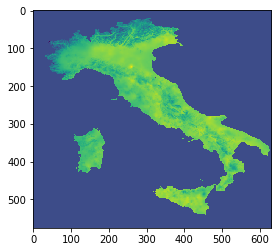

In [24]:
plt.imshow(T[5, :, :] * (T[5, :, :] > -9999.0))

In [25]:
with tiledb.DenseArray(radar_array, mode='r', ctx=TILEDB_CTX) as A:
    data = A[0:10,:,:]

In [26]:
vmi = data['VMI'] * (data['VMI'] > -9000.0)
sri = data['SRI'] * (data['SRI'] > -9000.0)

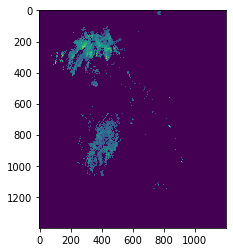

In [27]:
plt.imshow(vmi[0])